# Reflection


In the context of LLM agent building, reflection refers to the process of prompting an LLM to observe its past steps (along with potential observations from tools/the environment) to assess the quality of the chosen actions.
This is then used downstream for things like re-planning, search, or evaluation.



This notebook demonstrates a very simple form of reflection in LangGraph.

In [1]:
model_name = "gpt-4o-mini"

## Generate

For our example, we will create a "5 paragraph essay" generator. First, create the generator:


In [2]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

from langchain.chat_models import init_chat_model
chatmodel = init_chat_model(model_name, model_provider="azure_openai")


generate = prompt | chatmodel

In [3]:
essay = ""
request = HumanMessage(
    content="Write an essay on why the little prince is relevant in modern childhood"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

**The Relevance of "The Little Prince" in Modern Childhood**

Antoine de Saint-Exupéry's timeless tale, "The Little Prince," spanning over seven decades since its original publication, continues to enchant, teach, and resonate with children and adults alike. In a rapidly changing world driven by technology, social challenges, and shifting values, this poignant story offers meaningful reflections on the essence of childhood, relationships, and the pursuit of happiness. The relevance of "The Little Prince" in modern childhood is underscored by its emphasis on imagination, emotional intelligence, and the importance of genuine human connections amidst the complexities of contemporary life.

First and foremost, "The Little Prince" celebrates the power of imagination, a crucial element in childhood development. In an era where children are often inundated with screens and virtual experiences, the narrative encourages them to cherish their creative instincts. The story illustrates how the you

In [4]:
essay

'**The Relevance of "The Little Prince" in Modern Childhood**\n\nAntoine de Saint-Exupéry\'s timeless tale, "The Little Prince," spanning over seven decades since its original publication, continues to enchant, teach, and resonate with children and adults alike. In a rapidly changing world driven by technology, social challenges, and shifting values, this poignant story offers meaningful reflections on the essence of childhood, relationships, and the pursuit of happiness. The relevance of "The Little Prince" in modern childhood is underscored by its emphasis on imagination, emotional intelligence, and the importance of genuine human connections amidst the complexities of contemporary life.\n\nFirst and foremost, "The Little Prince" celebrates the power of imagination, a crucial element in childhood development. In an era where children are often inundated with screens and virtual experiences, the narrative encourages them to cherish their creative instincts. The story illustrates how t

### Reflect

In [6]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
from langchain.chat_models import init_chat_model
chatmodel = init_chat_model(model_name, model_provider="azure_openai")
reflect = reflection_prompt | chatmodel

In [7]:
reflection = ""
for chunk in reflect.stream({"messages": [HumanMessage(content=request.content + "\n" + essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

**Essay Critique and Recommendations**

Your essay titled "The Relevance of 'The Little Prince' in Modern Childhood" presents a thoughtful examination of why this classic tale continues to resonate with contemporary youth. The structure is clear, and you articulate your points well, referencing central themes of imagination, emotional intelligence, and human connections. However, there are areas where you can enhance your work to create a more compelling and comprehensive essay.

### Critique:

1. **Depth of Analysis:**
   - While you touch on significant themes, consider providing more in-depth examples or quotations from the text. For instance, rather than only summarizing the Little Prince’s encounters, delve into specific interactions to illustrate how they exemplify the themes you’re discussing.

2. **Cohesion and Transitions:**
   - Your essay could benefit from stronger transitions between paragraphs. Each paragraph introduces a new concept, but they can feel somewhat disjointed

In [8]:
reflection

'**Essay Critique and Recommendations**\n\nYour essay titled "The Relevance of \'The Little Prince\' in Modern Childhood" presents a thoughtful examination of why this classic tale continues to resonate with contemporary youth. The structure is clear, and you articulate your points well, referencing central themes of imagination, emotional intelligence, and human connections. However, there are areas where you can enhance your work to create a more compelling and comprehensive essay.\n\n### Critique:\n\n1. **Depth of Analysis:**\n   - While you touch on significant themes, consider providing more in-depth examples or quotations from the text. For instance, rather than only summarizing the Little Prince’s encounters, delve into specific interactions to illustrate how they exemplify the themes you’re discussing.\n\n2. **Cohesion and Transitions:**\n   - Your essay could benefit from stronger transitions between paragraphs. Each paragraph introduces a new concept, but they can feel somewh

### Repeat

And... that's all there is too it! You can repeat in a loop for a fixed number of steps, or use an LLM (or other check) to decide when the finished product is good enough.

In [9]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

**The Relevance of "The Little Prince" in Modern Childhood**

Antoine de Saint-Exupéry's "The Little Prince" has transcended time and cultural boundaries since its publication in 1943, captivating both children and adults across generations. This enchanting tale invites readers to reflect on essential life lessons about imagination, emotional intelligence, and the significance of authentic human connections. In today’s fast-paced and technologically driven world, the themes portrayed in "The Little Prince" continue to resonate profoundly with modern childhood, reminding young readers of the enduring values they must navigate amidst challenges unique to contemporary life.

To begin with, "The Little Prince" encourages a celebration of imagination, which plays a pivotal role in healthy childhood development. In a world increasingly dominated by screens and digital interactions, the story serves as a balm that fosters creativity and exploration. The many planets that the little prince vis

## Define graph

Now that we've shown each step in isolation, we can wire it up in a graph.

In [14]:
from typing import List, Sequence

from langgraph.graph import END, MessageGraph, START
import time

async def generation_node(state: Sequence[BaseMessage]):
    return await generate.ainvoke({"messages": state})


async def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    time.sleep(30)
    # First message is the original user request. We hold it the same for all nodes
    translated =  [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = await reflect.ainvoke({"messages": translated})
    # We treat the output of this as human feedback for the generator
    return HumanMessage(content=res.content)


builder = MessageGraph()
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: List[BaseMessage]):
    if len(state) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue,{END:END,'reflect':'reflect'})
builder.add_edge("reflect", "generate")
graph = builder.compile()

C:\Users\Anshu Pandey\AppData\Local\Temp\ipykernel_94612\1827069992.py:23: LangGraphDeprecatedSinceV10: MessageGraph is deprecated in LangGraph v1.0.0, to be removed in v2.0.0. Please use StateGraph with a `messages` key instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  builder = MessageGraph()


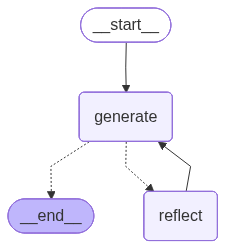

In [16]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
async for event in graph.astream(
    [
        HumanMessage(
            content="Generate an essay on the topicality of The Little Prince and its message in modern life"
        )
    ],
):
    ChatPromptTemplate.from_messages(event).pretty_print()
    print(list(event.values())[0].content)
    print("---")

In [ ]:
list(event.values())[0].content

'Thank you so much! I really appreciate your help and expertise.\n'

## Conclusion

Now that you've applied reflection to an LLM agent, I'll note one thing: self-reflection is inherently cyclic: it is much more effective if the reflection step has additional context or feedback (from tool observations, checks, etc.). If, like in the scenario above, the reflection step simply prompts the LLM to reflect on its output, it can still benefit the output quality (since the LLM then has multiple "shots" at getting a good output), but it's less guaranteed.
